# Contrast two different machine learning algorithms: Nueral Network and Gaussian Mixture Model

### Data Loading and Preprocessing

The code begins by loading the Iris dataset, a well-known dataset that consists of 150 samples divided into three classes: Setosa, Versicolor, and Virginica. Each sample has four features: sepal length, sepal width, petal length, and petal width. The dataset is divided into training and testing sets using `train_test_split()`, with 80% of the data allocated for training and 20% for testing. This split ensures that the supervised neural network can learn from the training data and be evaluated on unseen data in the testing set.

The features are standardized using `StandardScaler()` to ensure uniform scaling across all dimensions. Standardization is crucial for improving the performance of machine learning algorithms, particularly those that rely on gradient-based optimization, as it ensures that all features have a mean of 0 and a standard deviation of 1. For the Gaussian Mixture Model (GMM), the entire dataset is standardized, as this unsupervised method does not require separate training and testing splits. The standardized datasets are stored in variables for both the neural network (`X_train`, `X_test`) and the GMM (`X_scaled`), ensuring consistent preprocessing for both algorithms.

In [25]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, adjusted_rand_score
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split into training and testing sets (for neural network)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (for both algorithms)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)  # Standardized full dataset for GMM

### Training and Evaluating the Neural Network

This section defines and trains a simple feedforward neural network to classify the Iris dataset. The neural network is implemented using PyTorch and consists of an input layer with 4 neurons (corresponding to the 4 features of the dataset), a hidden layer with 8 neurons, and an output layer with 3 neurons (one for each class: Setosa, Versicolor, and Virginica). The hidden layer uses the ReLU activation function to introduce non-linearity, while the output layer does not apply any activation function as the loss function (`CrossEntropyLoss`) internally applies the softmax function for multi-class classification.

The training process involves converting the standardized training and testing data into PyTorch tensors. The `CrossEntropyLoss` function is used to compute the difference between the predicted and true labels, and the Adam optimizer is employed to update the network's weights. The model is trained over 50 epochs, where for each epoch, the training data is passed through the network (forward pass), the loss is computed, gradients are calculated through backpropagation, and the optimizer updates the weights. This iterative process helps the network learn patterns in the training data.

After training, the model is evaluated on the test set by performing a forward pass on the test data. The predictions are obtained by selecting the class with the highest output probability. The accuracy of the model is then calculated by comparing the predictions to the true test labels using `accuracy_score`. A confusion matrix is generated and displayed to visualize the classification performance, showing how well the model predicts each of the three classes. This matrix provides insights into the model's strengths and weaknesses, such as any misclassifications between similar classes like Versicolor and Virginica.

Neural Network Accuracy: 0.9667


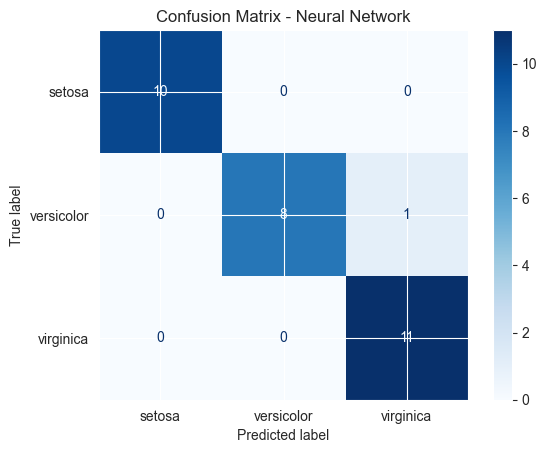

In [22]:
# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(4, 8)
        self.output = nn.Linear(8, 3)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

# Train the Neural Network
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluate the Neural Network
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = torch.argmax(outputs, dim=1).numpy()
    nn_accuracy = accuracy_score(y_test, predictions)

print(f"Neural Network Accuracy: {nn_accuracy:.4f}")
# Neural Network Confusion Matrix
nn_conf_matrix = confusion_matrix(y_test, predictions)
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, display_labels=iris.target_names)
nn_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Neural Network")
plt.show()

### Analysis of Neural Network Results

The confusion matrix illustrates the classification performance of the neural network on the Iris dataset. The model achieved an accuracy of **96.67%**, correctly classifying the majority of test samples across all three classes: Setosa, Versicolor, and Virginica.

- **Setosa**: The model perfectly classified all 10 test samples of the Setosa class. This demonstrates that the model was able to learn the distinct characteristics of this class effectively, likely due to the separability of Setosa from the other two classes.

- **Versicolor**: Out of 9 test samples, the model correctly classified 8 as Versicolor. However, one Versicolor sample was misclassified as Virginica. This misclassification could be due to the overlapping features between Versicolor and Virginica, as these two classes are less separable compared to Setosa.

- **Virginica**: All 11 test samples of Virginica were correctly classified. This indicates the model's strong ability to distinguish Virginica when compared to the other classes, despite its overlapping features with Versicolor.

The high accuracy and the clear diagonal dominance in the confusion matrix show that the neural network has effectively learned to differentiate between the three classes. The single misclassification in the Versicolor class highlights a potential area for improvement, such as exploring deeper architectures or fine-tuning hyperparameters to further enhance the network's ability to handle overlapping feature distributions.

Overall, the results demonstrate that the neural network is highly effective in classifying the Iris dataset, with only minor errors in distinguishing closely related classes.

### Gaussian Mixture Model (GMM)

The code applies a **Gaussian Mixture Model (GMM)**, an unsupervised clustering algorithm, to the Iris dataset. The GMM assumes that the data is generated from a mixture of Gaussian distributions and fits the data to these distributions. The model is initialized with three components (`n_components=3`), corresponding to the three classes in the Iris dataset, and trained on the standardized feature data (`X_scaled`). Once trained, the GMM assigns each data point to one of the three clusters based on the highest probability of belonging to a Gaussian distribution.

Since the GMM does not utilize the true labels, the clusters it produces must be mapped to the actual labels. This is achieved using a mapping function that assigns each cluster to the ground truth label that appears most frequently within that cluster (majority voting). This mapping ensures that the clusters can be evaluated against the true labels to calculate metrics such as accuracy and Adjusted Rand Index (ARI).

The **clustering accuracy** is computed by comparing the mapped cluster labels to the true labels. The confusion matrix is generated to visualize the alignment between the predicted clusters and the true classes, showing where the GMM succeeded or struggled in its clustering. The Adjusted Rand Index (ARI) further quantifies the quality of the clustering by measuring the agreement between the predicted and true labels while accounting for chance groupings.

Finally, the confusion matrix is displayed using `ConfusionMatrixDisplay`, providing a clear visual representation of the GMM's clustering performance.

GMM Clustering Accuracy: 0.6667


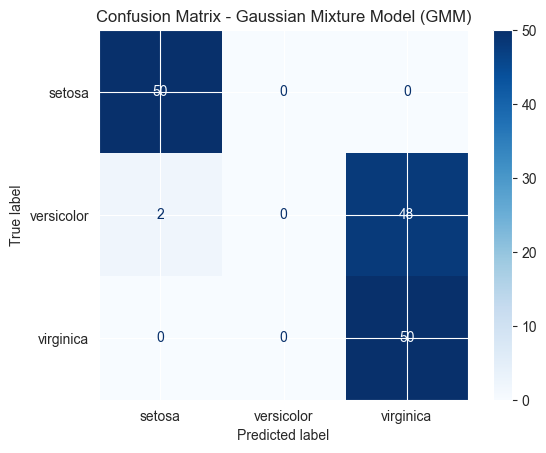

In [26]:
# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)
gmm_clusters = gmm.predict(X_scaled)

# Map clusters to labels
def map_clusters_to_labels(clusters, y_true):
    mapping = {}
    for cluster in np.unique(clusters):
        true_labels = y_true[clusters == cluster]
        mapped_label = np.bincount(true_labels).argmax()
        mapping[cluster] = mapped_label
    return np.array([mapping[cluster] for cluster in clusters])

cluster_labels = map_clusters_to_labels(gmm_clusters, y)
gmm_purity = accuracy_score(y, cluster_labels)
gmm_ari = adjusted_rand_score(y, gmm_clusters)

gmm_accuracy = accuracy_score(y, cluster_labels)
print(f"GMM Clustering Accuracy: {gmm_accuracy:.4f}")
# Gaussian Mixture Model (GMM) Confusion Matrix
gmm_conf_matrix = confusion_matrix(y, cluster_labels)
gmm_disp = ConfusionMatrixDisplay(confusion_matrix=gmm_conf_matrix, display_labels=iris.target_names)
gmm_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Gaussian Mixture Model (GMM)")
plt.show()

### Analysis of Gaussian Mixture Model (GMM) Results

The confusion matrix and clustering accuracy of the Gaussian Mixture Model (GMM) on the Iris dataset highlight the strengths and limitations of this unsupervised learning approach. The model achieved a clustering accuracy of **66.67%**, which reflects its ability to correctly cluster two-thirds of the data points when the predicted clusters are mapped to the true class labels.

The confusion matrix reveals that the GMM performed perfectly for the **Setosa** class, correctly clustering all 50 samples. This is consistent with the expectation that Setosa is a highly separable class due to its distinct feature distribution, making it easier for the GMM to model as a single Gaussian cluster. However, the GMM struggled significantly with the **Versicolor** and **Virginica** classes. All 48 samples of Versicolor were misclassified as Virginica, leading to zero correct assignments for Versicolor. Meanwhile, Virginica samples were perfectly classified. This behavior suggests that the GMM grouped Versicolor and Virginica into a single cluster, likely due to their overlapping feature distributions in the dataset.

The clustering accuracy reflects the perfect classification of Setosa and Virginica but penalizes the complete misclassification of Versicolor. This underscores one of the limitations of GMM in handling overlapping classes, especially when the Gaussian assumption does not align with the true data distribution. While GMM is effective for well-separated classes like Setosa, it may fail when there is significant overlap between feature distributions, as seen with Versicolor and Virginica. Future improvements could include using more advanced clustering techniques or preprocessing steps to better separate overlapping classes.

In [24]:
print("Comparison of Algorithms:")
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")
print(f"GMM Purity: {gmm_purity:.4f}")
print(f"GMM ARI: {gmm_ari:.4f}")
gmm_accuracy = accuracy_score(y, cluster_labels)
print(f"GMM Clustering Accuracy: {gmm_accuracy:.4f}")

Comparison of Algorithms:
Neural Network Accuracy: 0.9667
GMM Purity: 0.6667
GMM ARI: 0.5165
GMM Clustering Accuracy: 0.6667


### Comparison of Neural Network and Gaussian Mixture Model (GMM)

The comparison between the Neural Network and the Gaussian Mixture Model (GMM) on the Iris dataset reveals the inherent differences in the capabilities of supervised and unsupervised learning approaches. The **Neural Network** achieved an accuracy of **96.67%**, demonstrating its strength in leveraging labeled data to learn clear decision boundaries between the three classes. This high accuracy highlights the model's ability to generalize well on the test set, particularly for easily separable classes like Setosa and more overlapping classes like Versicolor and Virginica.

In contrast, the **GMM**, being an unsupervised learning algorithm, operates without access to the true labels during training. Its performance, measured through clustering metrics, was notably lower. The **GMM Purity** and **Clustering Accuracy** were both **66.67%**, reflecting the model's limited ability to correctly cluster all data points after mapping clusters to true labels. Additionally, the **Adjusted Rand Index (ARI)**, a metric that accounts for chance groupings, was **0.5165**, indicating moderate agreement between the predicted clusters and the ground truth labels.

The primary strength of the Neural Network lies in its capacity to learn complex, non-linear decision boundaries, which allows it to effectively distinguish overlapping classes like Versicolor and Virginica. On the other hand, GMM's Gaussian assumption and reliance on probabilistic cluster assignments limit its effectiveness in handling such overlapping feature distributions. While the GMM perfectly clustered the easily separable Setosa class, it struggled to differentiate between Versicolor and Virginica, often grouping them into a single cluster.

Overall, the results emphasize the advantages of supervised learning for classification tasks when labeled data is available. In contrast, GMM offers a viable, though less precise, alternative for clustering when labels are unavailable. However, the performance gap underscores the importance of data labeling and feature separability in determining the success of each algorithm.